In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from scipy.stats import chi2_contingency, mannwhitneyu, norm
import pingouin as pg
from tqdm.auto import tqdm
import plotly.express as px

In [2]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize': (14, 7)}
        )

## Проект: вариант 2
### Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) \
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных \
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. \
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему? \
Имеются ли различия в показателях и с чем они могут быть связаны? \
Являются ли эти различия статистически значимыми? \
Стоит ли запускать новую механику на всех пользователей? \
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [3]:
# # внешние ссылки на таблицы
groups_url = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
group_add_url = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
active_studs_url = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
checks_url = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [4]:
# # подготовка ссылок для загрузки в датафреймы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# # Получаем загрузочную ссылку
groups_final_url = base_url + urlencode(dict(public_key=groups_url))
response = requests.get(groups_final_url)
groups_download_url = response.json()['href']

group_add_final_url = base_url + urlencode(dict(public_key=group_add_url))
response = requests.get(group_add_final_url)
group_add_download_url = response.json()['href']

active_studs_final_url = base_url + urlencode(dict(public_key=active_studs_url))
response = requests.get(active_studs_final_url)
active_studs_download_url = response.json()['href']

checks_final_url = base_url + urlencode(dict(public_key=checks_url))
response = requests.get(checks_final_url)
checks_download_url = response.json()['href']

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
# загрузка датафреймов для проекта
groups = pd.read_csv(groups_download_url, sep=';')
group_add = pd.read_csv(group_add_download_url)
active_studs = pd.read_csv(active_studs_download_url)
checks = pd.read_csv(checks_download_url, sep=';')

Проверим как загрузились данные. Проверим на пропуски и дубликаты

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [8]:
groups.id.duplicated().sum()

0

In [9]:
groups.duplicated().sum()

0

In [10]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [12]:
group_add.id.duplicated().sum()

0

In [13]:
group_add.duplicated().sum()

0

In [14]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [15]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [16]:
active_studs.duplicated().sum()

0

In [17]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
checks.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


In [19]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [20]:
checks.student_id.duplicated().sum()

0

In [21]:
checks.duplicated().sum()

0

Проверили: все исходные данные не имеют пропусков и дубликатов

Для начала объединим 2 датасета: исходный - groups и "добавочный" group_add:

In [22]:
# Объединяем данные и заодно переименовываем столбец id  в student_id для удобства в следующих шагах
ab_groups = pd.concat([groups, group_add]).rename(columns={'id': 'student_id'})

In [23]:
ab_groups.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [24]:
# Проверили, что все id уникальны и количество равно количеству строк в датасете
# Также еще раз убедились, что все количество строк равно сумме строк в исходных датафреймах
ab_groups.student_id.nunique() \
== ab_groups.shape[0] \
== (groups.shape[0] + group_add.shape[0])

True

In [25]:
ab_groups.student_id.nunique()

74576

Теперь добавим данные об активности пользователей на период эксперимента

In [26]:
# Для начала добавим колонку-маркер активности:
# (1 - пользователь зашел на платформу во время эксперимента)
active_studs['active'] = 1

In [27]:
active_studs.head()

,student_id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [28]:
# Объединим левым джойном, чтобы не пропали интересующие нас записи
# Перезапишем датасет
ab_groups = ab_groups.merge(active_studs, on='student_id', how='left')

In [29]:
# Видим, что появились пропуски - это id пользователей которые не появлялись на платформе 
# во время проведения теста
ab_groups.isna().sum()

student_id        0
grp               0
active        66235
dtype: int64

In [30]:
# Заполним пропуски нулями. 
# Теперь у нас 2 категории пользователей: 
# 1 - проявили активность во время теста
# 0 - не проявили активность
ab_groups = ab_groups.fillna(0)

In [31]:
ab_groups.isna().sum()

student_id    0
grp           0
active        0
dtype: int64

In [32]:
# Присоединим к нашему датасету информацию по покупкам пользователей за время эксперимента
# заполним пропуски нулями: нет оплаты - значит ноль дохода
ab_groups = ab_groups.merge(checks, on='student_id', how='left').fillna(0)

In [33]:
ab_groups.head()

,student_id,grp,active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [34]:
# Посмотрим на соотношение количества пользователей 2-х групп
ab_groups.grp.value_counts(normalize=True).round(2)

B    0.8
A    0.2
Name: grp, dtype: float64

In [35]:
# Посмторим на описание оплат, активных пользователей
ab_groups.query('active == 1').describe()

,student_id,active,rev
count,8.341000e+03,8341.0,8341.000000
mean,2.448547e+06,1.0,56.083683
std,1.564978e+06,0.0,309.620349
min,1.627000e+03,1.0,0.000000
25%,1.118405e+06,1.0,0.000000
50%,2.094192e+06,1.0,0.000000
75%,3.638877e+06,1.0,0.000000
max,5.951797e+06,1.0,4650.000000


In [36]:
# Видим, что есть пользователи у которых проходила оплата во время эксперимента, 
# но они не были активны на платформе
ab_groups.query('active == 0').describe()

,student_id,active,rev
count,6.623500e+04,66235.0,66235.000000
mean,2.129987e+06,0.0,1.593297
std,2.902677e+06,0.0,38.031788
min,1.489000e+03,0.0,0.000000
25%,8.637525e+05,0.0,0.000000
50%,1.635302e+06,0.0,0.000000
75%,3.279154e+06,0.0,0.000000
max,2.010677e+08,0.0,1980.000000


In [37]:
# Видим, что распределены они между группами  примерно также
# *косвенно это говорит о том, что они такие же активные (т.е. также посещали платформу)
ab_groups.query('active == 0 & rev > 0').grp.value_counts(normalize=True).round(2)

B    0.81
A    0.19
Name: grp, dtype: float64

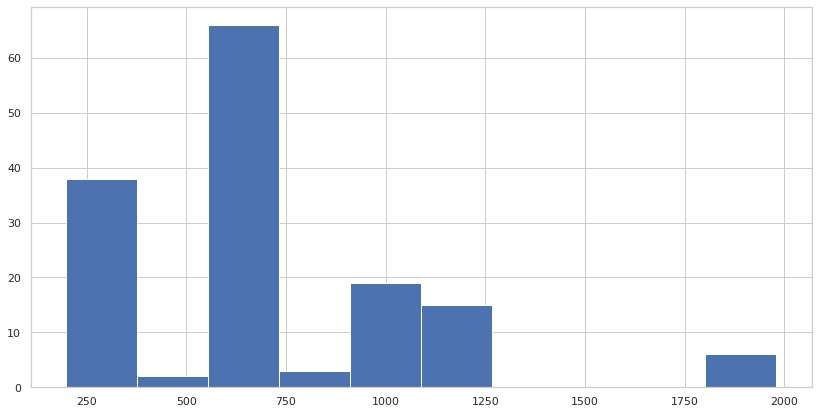

In [38]:
# Посмотрим на размеры этих оплат: они разные
ab_groups.query('active == 0 & rev > 0').rev.hist()

In [39]:
ab_groups.query('active == 0 & rev > 0').value_counts('rev')

rev
690.0000     61
290.0000     24
990.0000     19
1140.0000    14
199.0000     14
1900.0000     4
580.0000      4
840.0000      3
398.0000      2
1980.0000     1
1900.0001     1
1180.0000     1
630.0000      1
dtype: int64

Замечаем 2 вещи: 
1. Схожесть размеров оплат в 1900 и 1900.0001 - вероятно это ошибка в записи данных (т.к. 1 десятитысячная в обычных видах валют (не крипто) не встречается)
2. Мы помним, с описания распределения rev ранее: 75% квантиль = 1900

Посмотрим сколько таких значений в остальной части данных

In [40]:
# Оказывается их достаточно много (93) ~ 24% от всех оплат
# И самое ВАЖНОЕ: такие оплаты свойственны ТОЛЬКО группе B
ab_groups.query('active == 1 & rev == 1900').value_counts('grp')

grp
B    93
dtype: int64

In [41]:
# Еще раз посмотрим, кто оплачивал 1900 не заходя на платформу 
# и видим что это только предстваители группы B
ab_groups.query('active == 0 & rev == 1900')

,student_id,grp,active,rev
18700,926967,B,0.0,1900.0
46510,2388577,B,0.0,1900.0
70438,5004439,B,0.0,1900.0
74216,5599663,B,0.0,1900.0


### !!!Это важное наблюдение!!! 

Сам эксперимент нацелен на тестирование новой механики оплаты услуг на сайте.
Т.е. предполагается обязательная активность для совершения оплаты.
Здесь же мы видим, что прошли платежи другим способом (при отсутствии зафиксированной активности на платформе).
Как мы поняли из "расследования", скорее всего это ошибка в данных (пользователи были активны), т.к. определенный паттерн оплат характерен только для тестовой механики эксперимента (оплата на 1900 и только группой B). \
Была мысль, что это могут быть автоматические платежи, не предусматривающие вход на платформу, но характер сумм (очень разные, что обычно не свойственно подпискам - обычно до 5) говорит о малой вероятности такой версии. Более вероятно, что оплата без активности на платформе прошла по шаблонам онлайн-приложений банков.

В этом вопросе, в любом случае, обязательно необходимо разобраться с дата-инженерами, т.к. 149 оплат которые возможно все таки не стоит рассматривать в рамках эксперимента, это более чем существенная доля от всех оплат (более 27%).

Этот момент может поставить под сомнение достоверность дальнейших выводов основанных на статистических расчетах.

#### Итак:
1. Попробуем понять "природу" этой аномалии - возможно это связано с группой id, добавленных через 2 дня после эксперимента.
2. У нас есть пока только эти данные и пока не разберемся с причинами аномалий, будем работать именно с ними.
Значит, выборку с аномальной "активностью" выделим отдельно и будем сравнивать с ней как отдельно, так и в купе с общими данными.

In [42]:
# Проверим по добавленным id - как они связаны с аномальной активностью
# Создадим датасет только по добавленным id с нулевой активностью и проведенными оплатами
added_not_active = group_add.rename(columns={'id': 'student_id'}) \
.merge(active_studs, on='student_id', how='left') \
.fillna(0) \
.query('active == 0') \
.merge(checks, on='student_id', how='left').query('rev > 0')
added_not_active

,student_id,grp,active,rev


Видим, что данные по пользователям-участникам тестирования, добавленные через 2 дня не являются причиной аномалии.

In [43]:
# Подготовим датасеты для тестов:
# 1. а/б группы которые должны были бы быть рассмотрены:
# активность на платформе, оплата
active_a_group = ab_groups.query('active == 1 & rev > 0 & grp == "A"')
active_b_group = ab_groups.query('active == 1 & rev > 0 & grp == "B"')
# 2. а/б группы с аномалиями:
# не зафиксирована активность на платформе, но есть оплата
anomaly_a_group = ab_groups.query('active == 0 & rev > 0 & grp == "A"')
anomaly_b_group = ab_groups.query('active == 0 & rev > 0 & grp == "B"')
# 3. а/б группы со всеми пользователями:
# без учета активности, просто по факту проведенной оплаты
total_a_group = ab_groups.query('rev > 0 & grp == "A"')
total_b_group = ab_groups.query('rev > 0 & grp == "B"')

### Начнем с первой группы:

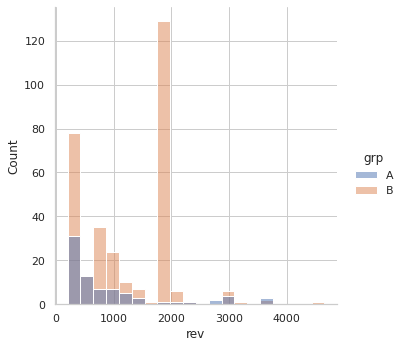

In [44]:
# Посмотрим на распределения: визуально они не нормальные: 
# у группы B несколько мод, а группа А скошена влево
sns.displot(data=ab_groups.query('active == 1 & rev > 0'), x="rev", hue="grp", bins=20)

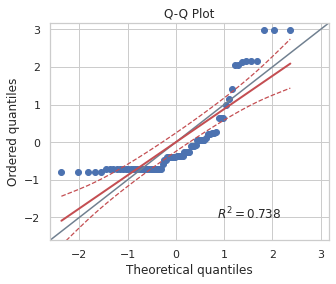

In [45]:
pg.qqplot(active_a_group.rev)

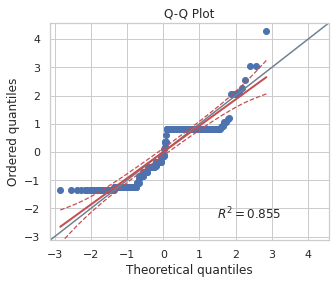

In [46]:
pg.qqplot(active_b_group.rev)

In [47]:
# тест Шапиро-Уилка: нормально ли распределение тестовой выборки A
# p < 0.05 - распределение считаем ненормальным
scipy.stats.shapiro(active_a_group.rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [48]:
# тест Шапиро-Уилка: нормально ли распределение тестовой выборки B
# p < 0.05 - распределение считаем ненормальным
scipy.stats.shapiro(active_b_group.rev)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [49]:
# проверяем гомогенность с помощью теста Левена
# p > 0.05 дисперсии гомогенны хотя и близко к пороговому значению
scipy.stats.levene(active_a_group.rev, active_b_group.rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

In [50]:
# тоже самое, но через pingoin
# p > 0.05 дисперсии гомогенны
pg.homoscedasticity(data=ab_groups.query('active == 1 & rev > 0'),
                    dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


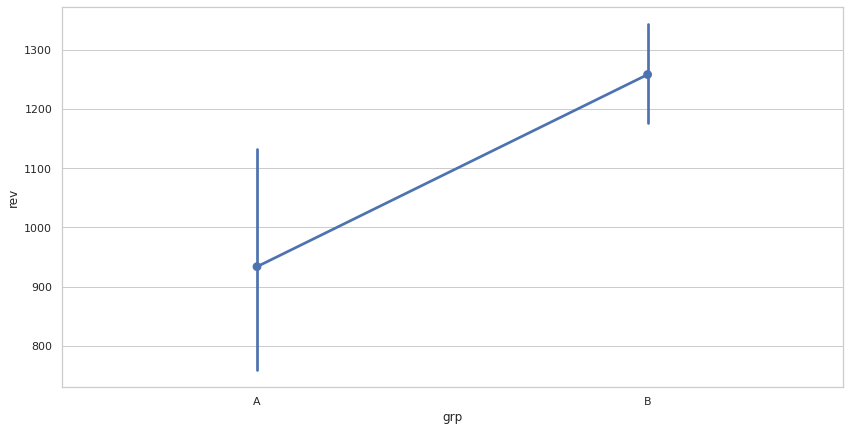

In [51]:
# Средние с доверительными интервалами
# Видим, что скорей всего статзначимые различия есть
sns.pointplot(x="grp", y="rev", data=ab_groups.query('active == 1 & rev > 0'))

Выбираем инструмент анализа: \
Т-тест Стьдента нам не подходит - мы помним, что он чувствителен к нормальности распределений, а наши выборки этому не соответствуют. \
С другой стороны нам известно, что при больших выборках нормальность распределения не так критична, как гомогенность дисперсий. В нашем случае дисперсии гомогенны. \
Также важно особенно для небольших выборок, чтобы размеры выборок были приблизительно равны (в нашем случае различия в 4 раза). \
Посмотрим, что покажет тест ANOVA.

In [104]:
# Конечно необходимо было простой anova
# Вывод в этом случае идентичен
pg.anova(data=ab_groups.query('active == 1 & rev > 0'),
               dv="rev", between="grp")

,Source,ddof1,ddof2,F,p-unc,np2
0,grp,1,390,9.820574,0.001856,0.024562


In [52]:
# Дисперсионный анализ методом Уэлча показал наличие статзначимых отличий (p-val < 0.05)
pg.welch_anova(data=ab_groups.query('active == 1 & rev > 0'),
               dv="rev", between="grp")

,Source,ddof1,ddof2,F,p-unc,np2
0,grp,1,106.981668,8.189268,0.00507,0.024562


In [53]:
# Также когда распределения ненормальные, хорошо работают непараметрические тесты
# Тест Мана_Уитни (2 группы):
mannwhitneyu(active_a_group.rev, active_b_group.rev)
# Тоже показывает наличие статзначимых различий

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Тем не менее, для проверки себя и исключения влияния ненормальности распределений и разности размеров выборок, дальше будем также использовать метод бутстрапа - т.е. сравнение распределений отклонений 2 выборок путем многочисленных сравнений.

In [123]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    u_test = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))  # mean() - применяем статистику
        u_test.append(mannwhitneyu(samples_1, samples_2)[1])
    pd_u_test = pd.DataFrame(u_test)  
    pd_boot_data = pd.DataFrame(boot_data)
    u_test_mean = pd_u_test.mean()
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
#     u_test = mannwhitneyu(samples_1, samples_2)    
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "u_test": u_test,
           "u_test_mean": u_test_mean}

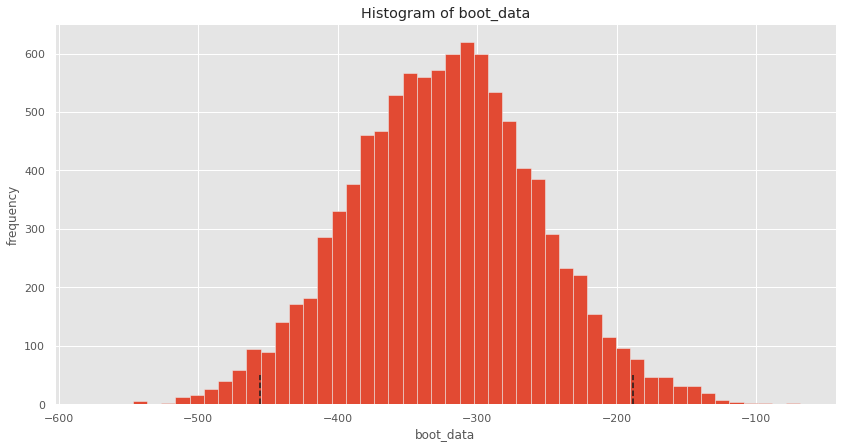

In [124]:
# в результате хранится разница двух распределений, ДИ и pvalue для bootstrap по средним
booted_data_mean = get_bootstrap(active_a_group.rev, 
                                 active_b_group.rev, 
                                 boot_it=10000, 
                                 statistic=np.mean)

In [125]:
# p-value для bootstrap по разницам значений средних
# можно считать статистически значимыми различия между группами (p-value < 0.05)
booted_data_mean["p_value"]

1.4881743941164256e-06

In [126]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# И в этот раз значение p-value (< 0.05) говорит о том, что мы можем отклонить нулевую гипотезу
booted_data_mean['u_test_mean']

0    0.000043
dtype: float64

In [127]:
# диапазон 95% распределения разниц
# значение 0 за пределами 95% диапазона:
# есть статзначимые различия
booted_data_mean["ci"]

,0
0.025,-455.964585
0.975,-188.163068


#### Вывод №1: 
Группы имеют статзначимое различие средних (для медиан также статзначиые различия если поменять параметр теста бутсрап)

### Теперь сравним группы из аномальной выборки между собой:

In [128]:
# Применим опять непараметрический тест Мана_Уитни (2 группы)
mannwhitneyu(anomaly_a_group.rev, anomaly_b_group.rev)
# Нет статзначимых различий

MannwhitneyuResult(statistic=1593.0, pvalue=0.464814175436539)

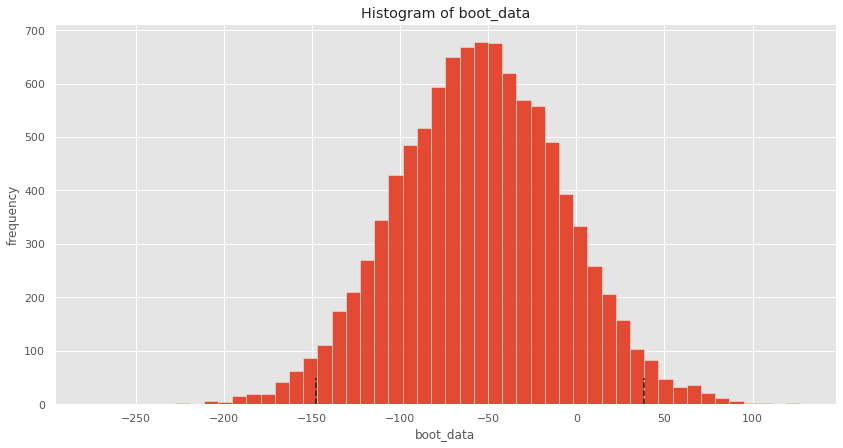

In [129]:
# Применим бутстрап для аномальной выборки
booted_data_mean = get_bootstrap(anomaly_a_group.rev, 
                                 anomaly_b_group.rev, 
                                 boot_it=10000, 
                                 statistic=np.mean)

In [61]:
# p-value для bootstrap по разницам значений средних
# нельзя считать статистически значимыми различия между группами (p-value > 0.05)
booted_data_mean["p_value"]

0.26380188274522753

In [130]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# И в этот раз значение p-value (> 0.05) говорит о том, что мы не можем отклонить нулевую гипотезу
booted_data_mean['u_test_mean']

0    0.319535
dtype: float64

In [131]:
# диапазон 95% распределения разниц
# значение 0 в пределах 95% диапазона:
# говорить о статзначимых различиях нельзя
booted_data_mean["ci"]

,0
0.025,-147.46875
0.975,38.18500


#### Вывод №2: 
Группы из аномальной выборки не имеют статзначимых различий средних (для медиан аналогично). \
При этом при сравнении без них мы статзначимо по всем тестам подтвердили наличие различий. \
Попробуем дальше соединить аномалии с валидными записями и провести тесты

### Теперь сравним группы включающие как аномалии, так и удовлетворяющие условию теста записи между собой:

In [132]:
# Для начала опять непараметрический тест Мана_Уитни (2 группы):
mannwhitneyu(total_a_group.rev, total_b_group.rev)
# Группы даже с учетом аномалий, имеют статзначимые различия

MannwhitneyuResult(statistic=17862.0, pvalue=0.00019316054996380152)

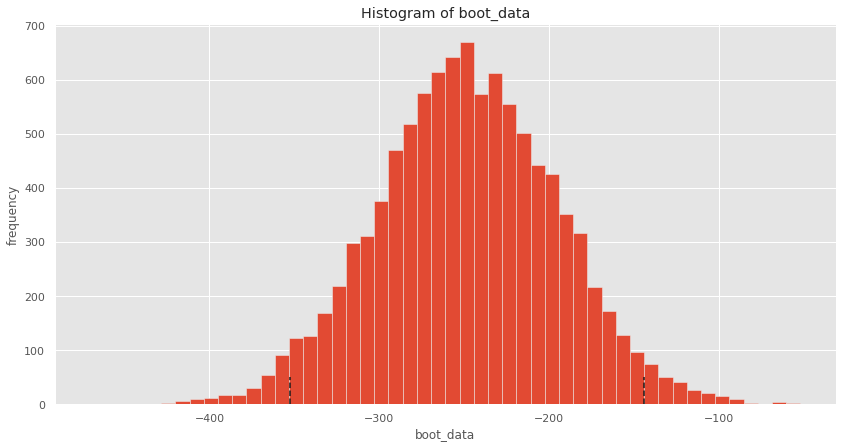

In [133]:
# Теперь bootstrap
booted_data_mean = get_bootstrap(total_a_group.rev, 
                                 total_b_group.rev, 
                                 boot_it=10000, 
                                 statistic=np.mean)

In [134]:
# p-value для bootstrap по разницам значений средних
# можно считать статистически значимыми различия между группами (p-value < 0.05)
booted_data_mean["p_value"]

2.5844193177905035e-06

In [135]:
# То же самое, но через непараметрический u-тест Мана-Уитни
# И в этот раз значение p-value (< 0.05) говорит о том, что мы можем отклонить нулевую гипотезу
booted_data_mean['u_test_mean']

0    0.000025
dtype: float64

In [68]:
# диапазон 95% распределения разниц
# значение 0 в пределах 95% диапазона:
# можно говорить о статзначимых различиях
booted_data_mean["ci"]

,0
0.025,-347.254039
0.975,-145.012336


#### Вывод №3: 
Группы из общей выборки имеют статзначимые различия средних (для медиан аналогично). \
Добавление аномальных данных несколько снизило статзначимость результатов (p-value), но тем не менее им можно доверять. \
По всей видимости аномальная выборка содержит как валидные записи для условий экспермиента (но с ошибками), так и не относящиеся к условиям эксперимента. \
Это значит, что необходимо дальше разбираться в природе возникновения этих аномалий.

Для подведения итогов возьмем информацию по общей группе (т.к. мы не смогли окончательно доказать валидность или ошибочность данных в аномальных записях)

In [136]:
ARPPU = (total_b_group.rev.mean() - total_a_group.rev.mean()).round(2)
print(f'ARPPU группы A равно {round(total_a_group.rev.mean(),2)} \n\
ARPPU группы B равно {round(total_b_group.rev.mean(),2)} \n\
Увеличение ARPPU при внедрении новой механики оплаты составило {ARPPU} \
({round(ARPPU / total_a_group.rev.mean() * 100, 2)}%) ')

ARPPU группы A равно 860.71 
ARPPU группы B равно 1108.82 
Увеличение ARPPU при внедрении новой механики оплаты составило 248.11 (28.83%) 


In [137]:
# т.к. у нас каждая запись уникальна - то среднее значение по оплатам и есть ARPPU 
# (в выборках у нас только платящие пользователи)

### Итого:
* мы отклонили нулевую гипотезу о равенстве средних оплат размеров оплат, и статистически это доказали
* мы рекомендуем внедрить новую механику оплаты, т.к. ожидаем увеличение среднего размера оплаты на платящего пользователя 
#### Осталось проверить не стало ли этих пользователей меньше - может быть конверсия в покупку упала и по итогу мы получим меньший доход. Посчитаем ARPU и CR

Важно: дальше будем смотреть только по общей группе, т.к. делать выводы принял решение (см. выше вывод №3) именно по ней

#### Расчет ARPU и проверка разницы средних отклонений (статзначимость):

In [138]:
# Подготовим данные
# Теперь нам нужны более широкие выборки - в т.ч. и по пользователям не оплатившим
# Соединяем данные аномалии и всех активных с разбивкой по группам
group_a_arpu = pd.concat([ab_groups.query('active == 1 & grp == "A"'), 
          ab_groups.query('active == 0 & rev > 0 & grp == "A"')])
group_b_arpu = pd.concat([ab_groups.query('active == 1 & grp == "B"'), 
          ab_groups.query('active == 0 & rev > 0 & grp == "B"')])
# т.е. сейчас всех пользователей вне зависимости от признака "active" принимаем за активных 
# если они оплатили

В этот раз будем использовать bootstrap

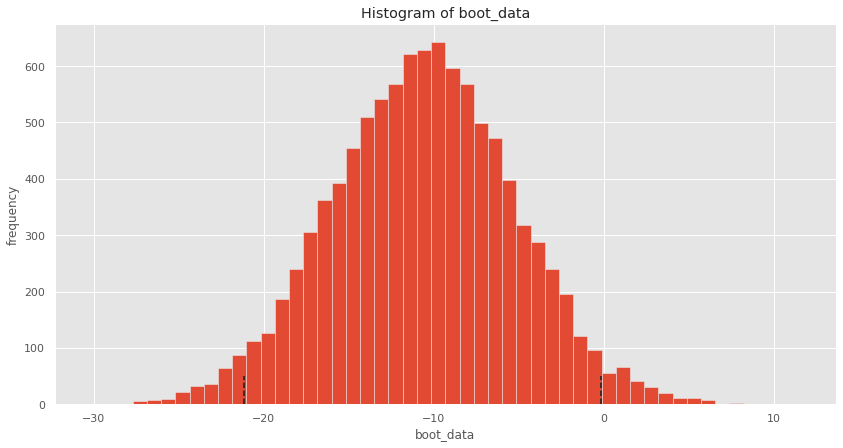

In [140]:
booted_data_mean = get_bootstrap(group_a_arpu.rev, 
                                 group_b_arpu.rev, 
                                 boot_it=10000, 
                                 statistic=np.mean)

In [141]:
# p-value для bootstrap по разницам значений средних
# можно считать статистически значимыми различия между группами (p-value < 0.05)
# Но также нужно заметить, что значение погранично
booted_data_mean["p_value"]

0.04677092785985486

In [149]:
# диапазон 95% распределения разниц
# значение 0 в пределах 95% диапазона:
# можно говорить о статзначимых различиях
booted_data_mean["ci"]

,0
0.025,-21.180013
0.975,-0.149416


In [144]:
ARPU = (group_b_arpu.rev.mean() - group_a_arpu.rev.mean()).round(2)
print(f'ARPU группы A равно {round(group_a_arpu.rev.mean(),2)} \n\
ARPU группы B равно {round(group_b_arpu.rev.mean(),2)} \n\
Изменение ARPU при внедрении новой механики оплаты составило {ARPU} \
({round(ARPU / group_a_arpu.rev.mean() * 100, 2)}%) ')

ARPU группы A равно 58.77 
ARPU группы B равно 69.51 
Изменение ARPU при внедрении новой механики оплаты составило 10.74 (18.27%) 


Мы видим рост ARPU, и можем говорить о статзначимости изменений при альфа равном 0.05

#### Теперь поcмотрим на изменение CR:

In [150]:
# Соединим датасеты так как дальше это потребуется
total_df_ab_groups = pd.concat([group_a_arpu, group_b_arpu])

In [151]:
# Добавим категориальную колонку по условию покупки
total_df_ab_groups['conv'] = total_df_ab_groups.rev > 0

In [152]:
CR_A = round(total_df_ab_groups.query('grp == "A" & rev > 0').student_id.count() / \
total_df_ab_groups.query('grp == "A" & rev == 0').student_id.count() \
* 100, 2)
CR_B = round(total_df_ab_groups.query('grp == "B" & rev > 0').student_id.count() / \
total_df_ab_groups.query('grp == "B" & rev == 0').student_id.count() \
* 100, 2)
print(f'CR контрольной группы А равен {CR_A}%\n\
CR тестовой группы В равен {CR_B}%\n\
Разница составила {round(CR_B - CR_A, 2)}%')

CR контрольной группы А равен 7.33%
CR тестовой группы В равен 6.69%
Разница составила -0.64%


#### Попробуем оценить статзначимость этой разницы через взаимосвязь группы и факта оплаты:

In [153]:
# Посмотрим визуально на распределения конверсий в зависимости от групп:
# True - сконвертировался в покупку
# False - нет
fig = px.histogram(total_df_ab_groups[['grp', 'conv']], x='grp', 
                   color='conv')
fig.show()

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [154]:
ab_conv_cross_group = pd.crosstab(total_df_ab_groups.grp, total_df_ab_groups.conv)

In [155]:
ab_conv_cross_group

conv,False,True
grp,,
A,1460,107
B,6489,434


In [156]:
# Применим метод хи-квадрата - определим связи групп и количества фактов конверсий
stat, p, dof, expected = chi2_contingency(ab_conv_cross_group)

In [157]:
stat, p

(0.579666003588264, 0.4464432666411111)

Интерпретируем результат:

In [158]:
"""prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')"""

"prob = 0.95\ncritical = chi2.ppf(prob, dof)\nif abs(stat) >= critical:\n    print('Отклоняем H0')\nelse:\n    print('Не отклоняем H0')"

In [159]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0, статзначимых различий нет')

Не отклоняем H0, статзначимых различий нет


## Подведем summary по итогам эксперимента:
##### 1. В ходе подготовки данных и при их исследовании мы определили наличие аномальных записей. Идентифицировать их ошибочность в рамках эксперимента или валидность в рамках условий мы однозначно не смогли. Необходимо обязательно разобраться в природе этих аномальных записей.
##### 2. Тем не менее мы определили, что в обоих случаях (принимая эти аномалии, либо исключая) наш эксперимент можно считать успешным. Мы получили статзначимые различия между группами А и Б.
###### ARPPU  в тестовой группе Б вырос более чем на 28%. 
###### ARPU  в тестовой группе Б вырос более чем на 18%. 
##### 3. Также мы проверили изменение CR. Статзначимого изменения не обнаружено.

### Мы можем рекомендовать запуск новой механики оплаты для всех пользователей, положительные изменения статзначимы, отрицательные статзначимые изменения не выявлены.

### Задание 2. SQL
#### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица peas:

Название атрибута	Тип атрибута 	Смысловое значение

*** st_id*** int*** ID ученика***  \
*** timest*** timestamp*** Время решения карточки***  \
*** correct*** bool*** Правильно ли решена горошина?***  \
*** subject*** text*** Дисциплина, в которой находится горошина***  \
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года. \
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [88]:
import pandahouse as ph

In [89]:
# Объявляем параметры подключения
connection = dict(database = 'default',
                host = 'https://clickhouse.lab.karpov.courses',
                user = 'student',
                password = 'dpo_python_2020')

In [90]:
# Пишем запрос, и получаем данные из clickhouse в pandas dataframe
# 1. Сначала пишем, что хотим в итоге вывести 
# (по задаче - количество студентов с результатом 20 корректных задач за март 2020 года)
# Считаем уникальные записи
# 2. Вкладываем подзапрос, в котором считаем количество правильных решений с группировкой 
# по id студента (можно суммировать - в нашем случае равнозначно)
# 3. До группировки а значит и до вычислений заводим условия отбора:
# Дата - приводим к началу месяца и преобразовываем в формат datetime (для pandas)
# Правильность решения - correct == 1
# 4. Уже после вычислений, проводим фильтрацию по условию более 20 правильных заданий
good_students_query = """
SELECT COUNT(DISTINCT st_id) as "Количество усердных студентов"
FROM
(
SELECT st_id,
COUNT(correct) as correct_count
FROM default.peas
WHERE toStartOfMonth(toDateTime(timest)) = '2020-03-01' AND correct = 1
GROUP BY st_id
HAVING correct_count >= 20
)
"""
good_students_count_2020_03 = ph.read_clickhouse(good_students_query, connection=connection)

In [91]:
# Строго говоря, в условии задачи сказано "правильно решил 20 задач" 
# Т.е. не говорится о равенстве статуса "усердный студент" при превышении этого значения
# Но я принял в условии решения, что это подразумевается
# В любом случае таких студентов нет.
good_students_count_2020_03

,Количество усердных студентов
0,0


 Также можно дополнить, что предыдущий запрос не учитывает вероятность задвоения записей (полных дублей).
 Но так как результат все равно нулевой, то это не принципиально.
 Так или иначе я проверил (см. ниже), что полных дублей нет в исходном датасете, иначе можно было бы завернуть в условие по их исключению.

In [92]:
doubles_query = """
SELECT
st_id,
correct,
subject,
toDateTime(timest) as timest
FROM
peas
GROUP BY
st_id, 
correct,
subject,
timest
HAVING 
COUNT(*) > 1
"""
doubles = ph.read_clickhouse(doubles_query, connection=connection)
doubles

,st_id,correct,subject,timest


#### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

*** Название атрибут*** Тип атрибута*** Смысловое значение*** \
*** st_id*** int*** ID ученика***  \
*** test_grp*** text*** Метка ученика в данном эксперименте*** 

и final_project_checks:

*** Название атрибута*** Тип атрибута *** Смысловое значение*** \
*** st_id*** int *** ID ученика*** \
*** sale_time*** timestamp*** Время покупки*** \
*** money*** int*** Цена, по которой приобрели данный курс*** \
*** subject*** text*** Дисциплина, на которую приобрели полный доступ*** \
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* CR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

#### После overview датасетов:
Очень странная задача или правильней сказать: странные исходные данные и условия эксперимента. \
Странности:
1. Датасеты имеют одинаковое количество строк. Колонка с id пользователей во всех датасетах одинаковая.
2. Даже в датасете с разбивкой по группам: одному id соответствует несколько значений групп в эксперименте.
3. В лимит по 30 "горошинам" никто не упирается и тем не менее, все покупают те или иные курсы.
4. Мало того, один и тот же id может несколько раз оплатить один и тот же курс.
5. Еще "хуже" (в плане понимания адекватности происходящего), некоторые покупают курс (даже не один раз) и не разу не пытаются решать задачи.

Но какие есть данные - такие есть. Сделаю пару предположений и допущений:
1. Эксперимент продолжительный и судя по тому, что один и тот же пользователь в разные даты по разному относится к группе, сделаем допущение, что он может пользоваться как новой системой оплаты так и старой. А значит нам надо смотреть не на группу у пользователя как таковую, а на event (факт покупки)
2. Есть предположение, что 3 датасета это разбивка одного и того же на составлющие с выделением ключа (id). Основано оно на п.1 странностей. Поэтому в дальнейшем я эти датасеты буду технически джойнить, но фактически конкатенировать. \
Единственная поправка - в studs сортировка по id и потом по test_grp по алфавиту(сначала new затем old). А в остальных дата по возрастанию. Я сделал допущение, что логически значения old надо развернуть и поставить в начало.
3. Так как параметр активности не определен в условии, я принял пользователей с активностью (учебой) в последнем месяце* за активных. * В моем условии строгое указание от 1 декабря 2020, но в реальной задаче можно было бы от today завязать.

In [93]:
metrics_query = """

SELECT

--Определяем, что хотим получить в итоговой таблице:
-- Общая выручка, Средний чек, ARPU, СК, CR, CR активных, CR активных по математике

    test_grp,
    ROUND(sum(money), 2) as Total_revenue,
    ROUND(avg(money), 2) as Average_check,
    ROUND(sum(money) / uniqExact(st_id), 2) as ARPU,
    ROUND(sumIf(money, active > 0) / uniqExact(st_id), 2) as ARPAU,
    ROUND((countIf(st_id, money > 0) / count (money)) * 100, 2) as CR,
    ROUND((countIf(st_id, money > 0 and active > 0) / count (money)) * 100, 2) as CR_active,
    ROUND(sum(math_bought) / sum(math_active) * 100, 2) as CR_active_in_math
FROM(

-- Здесь и далее применил нумерацию строк (num) для создания уникального ключа для джойнов

SELECT rowNumberInAllBlocks() AS num,
       st_id,
       subject AS subject_bought,
       toDateTime(sale_time) AS sale_time,
       money,
       test_grp,
       subject_peas,
       toDateTime(timest) AS study_time,
       correct,
       study_time >= '2020-12-01' as active,
       if((subject_bought='Math'), 1, 0) as math_bought,
       if((subject_peas='Math'), 1, 0) as math_active
FROM
  (SELECT toDateTime(sale_time) AS sale_time,
          money,
          subject
   FROM final_project_check) AS l
LEFT JOIN
  (SELECT rowNumberInAllBlocks() AS num,
          st_id,
          toDateTime(timest) AS timest,
          correct,
          subject AS subject_peas,
          test_grp
   FROM
     (SELECT *
      FROM peas) AS l
   LEFT JOIN
     (SELECT rowNumberInAllBlocks() AS num,
             st_id,
             test_grp
      FROM
        (SELECT *
         FROM studs
         ORDER BY st_id ASC, test_grp DESC)) AS r USING num) AS r USING num  
)
GROUP BY test_grp
"""
Metrics = ph.read_clickhouse(metrics_query, connection=connection)

Пояснение:
В вывод добавил общую выручку и средний чек. Решил, что для таких странных вводных, дополнительная информация не будет лишней.

CR из активности по математике показал за весь период - в задаче сказано не об активных пользователях в математике, а об активности в математике вообще. Хотя можно было бы и за последний месяц. CR больше 100 - это эффект от наших допущений и странностей (см. 4, 5), что мы смотрим на event (покупки) в паре с id, а не id по отдельности.  \
Иначе вообще тогда никакого смысла бы не было в этих метриках.

In [94]:
Metrics

,test_grp,Total_revenue,Average_check,ARPU,ARPAU,CR,CR_active,CR_active_in_math
0,new,1730000,16960.78,59655.17,11724.14,100.0,20.59,125.00
1,old,1705000,17397.96,58793.10,0.00,100.0,0.00,77.27


### Задание 3. Python
#### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Для этого нам нужен сам файл groups_add.csv (ссылка на него) и общий датасет.
Ранее для удобства и читаемости кода я создавал маленькие датасеты с разбивкой по условиям (группа, оплата, активность)
Сейчас для функции удобней будет работать с одним общим датасетом с разными фильтрами.

Также я решил, что очевидно задача не только метрики пересчитывать, но и понимать успешность протекания эксперимента. Поэтому помимо простого расчета метрик в функцию заведем пересчет статзначимости метрик.

In [95]:
# Ничего выдумывать не будем - просто возьму ссылку на файл которую уже использовали.
# При необходимости можно будет в функцию завернуть ввод ссылки например или поиск пути.
# Но так как дополнительных условий не описано в задаче - оставим статичную ссылку.
# path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-nekrasov-21/Final_project/group_add.csv'
path = group_add_download_url

Так как мы уже выяснили, что непараметрические тесты работают корректней с нашими данными, в функцию я ввел расчет значений p-value через непараметрический тест Мана-Уитни

In [171]:
# Сначала изменим функцию бутсрапа: уберем визуализацию (для нашей задачи сейчас она не понадобится)
def get_bootstrap_no_vis(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    u_test = mannwhitneyu(samples_1, samples_2)    
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value,
            "u_test": u_test}

In [172]:
# На вход функции будем подавать ссылку на файл
def ab_test_result_metrics(path):
    # Для начала создаем базовый датасет
    groups_add_df = pd.read_csv(path)
    # Заголовки согласно условию могут отличаться, поэтому приводим к нужным
    # Подразумеваем, что порядок столбцов и их кол-во корректны
    # Никаких проверок и сортировок не накручиваем - только если потребуется
    groups_add_df.columns = ['student_id', 'grp']
    # Добавляем связку данных по активности и покупкам
    groups_add_df = groups_add_df.merge(active_studs, on='student_id', how='left') \
                                 .merge(checks, on='student_id', how='left').fillna(0)
    # Предобработанный groups_add соединяем с основным датасетом
    # Но также вводим удаление дубликатов - на случай если функцию по таймеру запустят 
    # или случайно несколько раз один и тот же добавочный файл
    ab_groups_added = ab_groups.append(groups_add_df).drop_duplicates()
    # Дальше создаем вспомогательные датасеты с нашими метриками
    arppu = ab_groups_added.query('rev > 0') \
                .groupby('grp', as_index=False) \
                .agg({'rev': 'mean'}) \
                .round(2) \
                .rename(columns={'rev': 'ARPPU', 'grp': 'Group'})
    arpu = ab_groups_added.query("(active == 1) | (active == 0 & rev > 0)") \
                .groupby('grp', as_index=False) \
                .agg({'rev': 'mean'}) \
                .round(2) \
                .rename(columns={'rev': 'ARPU', 'grp': 'Group'})
    cr = pd.DataFrame(data= \
    round(
    (ab_groups_added.query('rev > 0') \
         .groupby('grp', as_index=False) \
         .student_id.count() \
         .student_id \
            / 
    ab_groups_added.query('active == 1 & rev == 0') \
         .groupby('grp', as_index=False) \
         .student_id \
         .count() \
         .student_id) \
         * 100, 2)
            ).rename(columns={'student_id': 'CR, %'})
    # Соединем все в один новый и трансформируем для красоты
    ab_results = pd.concat([arppu.merge(arpu, on='Group'), cr], axis=1).T.reset_index()
    # Немного мудрено: вытаскиваем первую строку в названия колонок
    ab_results = ab_results.rename(columns=ab_results.iloc[0]).drop(ab_results.index[0]) \
    .rename(columns={'Group': 'Metrics'})
    # Дальше собираем нашу статистику (p-values)
    
    booted_data_mean_arppu = get_bootstrap_no_vis(ab_groups_added \
                            .query('rev > 0 & grp == "A"').rev, 
                            ab_groups_added.query('rev > 0 & grp == "B"').rev, 
                                 boot_it = 10000, 
                                 statistic = np.mean)
    
    booted_data_mean_arpu = get_bootstrap_no_vis(ab_groups_added \
                            .query("grp == 'A' & (active == 1) | \
                            (active == 0 & rev > 0 & grp == 'A')").rev, 
                            ab_groups_added.query("grp == 'B' & (active == 1) | \
                            (active == 0 & rev > 0 & grp == 'B')").rev, 
                                 boot_it = 10000, 
                                 statistic = np.mean)
    
    ab_groups_added['conv'] = ab_groups_added.rev > 0
    ab_cross_group = pd.crosstab(ab_groups_added \
                       .query("(active == 1) | (active == 0 & rev > 0)").grp,
                       ab_groups_added.query("(active == 1) | \
                       (active == 0 & rev > 0)").conv)
    stat, p, dof, expected = chi2_contingency(ab_cross_group)
    
    p_value_arppu = booted_data_mean_arppu["p_value"]
    p_value_arpu = booted_data_mean_arpu["p_value"]
    p_value_cr = p
    
    # Создаем список из значений p-value
    p_values = [p_value_arppu, p_value_arpu, p_value_cr]
    # Создаем колонку с расчетом разницы между группами
    ab_results['Difference'] = ab_results.B - ab_results.A
    # Создаем колонку со значениями p-value
    ab_results['p-val'] = p_values
    # Выводим таблицу с результатами
    return ab_results

In [173]:
ab_results = ab_test_result_metrics(path)
ab_results

,Metrics,A,B,Difference,p-val
1,ARPPU,860.71,1108.82,248.11,0.000002
2,ARPU,58.77,69.51,10.74,0.046420
3,"CR, %",7.33,6.69,-0.64,0.446443


#### 3.2 Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [174]:
def show_results(table_results):
    # Для начала нам надо будет преобразовать таблицу получаемую из прошлой функции
    # Там мы ее сделали такой для удобства восприятия, сейчас удобней сгруппировать колонки A и B
    p_val = table_results["p-val"]
    table_results = table_results.drop(columns=['Difference', 'p-val']).T.reset_index()
    table_results = table_results.rename(columns=table_results.iloc[0]) \
    .drop(table_results.index[0]).rename(columns={'Metrics': 'Group'})
    # Задаем настройки графиков
    plt.figure(figsize=(8,6), dpi= 130)
    sns.set_theme(style="whitegrid")
    
    # Настраиваем вывод (несколько графиков на одном выводе)
    plt.subplot(1, 5, 1)
    sns.barplot(x="Group", y="ARPPU", data=table_results)
    # Добавляем значение p-value в записm под осью Х
    plt.xlabel(f'p-value: {round(p_val[1],3)}')
    plt.ylabel('Средний доход')
    plt.title("ARPPU")
    
    plt.subplot(1, 5, 3)
    sns.barplot(x="Group", y="ARPU", data=table_results)
    # Добавляем значение p-value в записm под осью Х
    plt.xlabel(f'p-value: {round(p_val[2],3)}')
    plt.ylabel('Средний доход')
    plt.title("ARPU")
    
    plt.subplot(1, 5, 5)
    sns.barplot(x="Group", y="CR, %", data=table_results)
    # Добавляем значение p-value в записm под осью Х
    plt.xlabel(f'p-value: {round(p_val[3],3)}')
    plt.ylabel('Проценты')
    plt.title("CR")

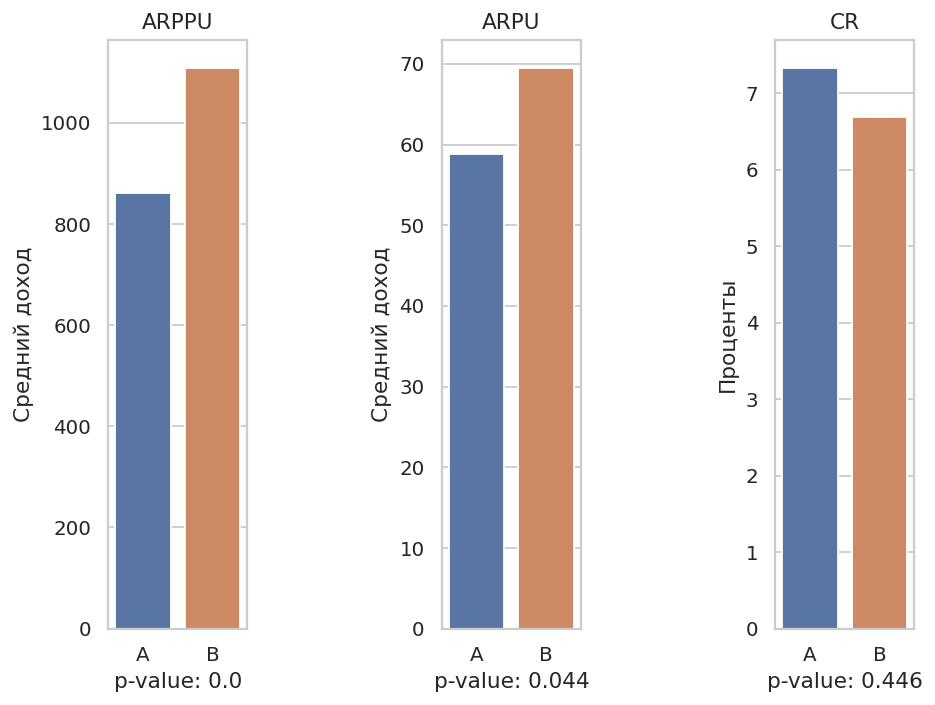

In [169]:
# Можно завернуть функцию расчета в функцию визуализации для обновления данных,
# либо имеющуюся таблицу, если не требуется обновлять.
# show_results(ab_test_result_metrics(path))
show_results(ab_results)